# <a id='toc1_'></a>[__Решающие деревья и их композиции в задаче классификации рукописных цифр__](#toc0_)

**Содержание**<a id='toc0_'></a>    
- [__Решающие деревья и их композиции в задаче классификации рукописных цифр__](#toc1_)    
  - [__Теория и примеры__](#toc1_1_)    
  - [__Импорты и настройки__](#toc1_2_)    
  - [__Обзор данных__](#toc1_3_)    
  - [__Оценка качества__](#toc1_4_)    
  - [__Одиночное ДПР с параметрами по умолчанию__](#toc1_5_)    
  - [__Бэггинг над ДПР__](#toc1_6_)    
  - [__Бэггинг: случайные признаки один раз на все базовое дерево__](#toc1_7_)    
  - [__Бэггинг: случайные признаки при построении каждой вершины дерева__](#toc1_8_)    
  - [__Случайный лес__](#toc1_9_)    
    - [__Выводы__](#toc1_9_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

***
## <a id='toc1_1_'></a>[__Теория и примеры__](#toc0_)

* [__ml_trees.ipynb__](https://github.com/EvgenyMeredelin/machine-learning-notes-and-codes/blob/main/ml_trees/ml_trees.ipynb)
* [__ml_resampling_and_ensembles.ipynb__](https://github.com/EvgenyMeredelin/machine-learning-notes-and-codes/blob/main/ml_resampling_and_ensembles/ml_resampling_and_ensembles.ipynb)

***
## <a id='toc1_2_'></a>[__Импорты и настройки__](#toc0_)

In [1]:
# стандартная библиотека
from collections.abc import Iterable

In [2]:
# сторонние библиотеки
from sklearn.datasets import load_digits
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib, matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
# глобальные настройки графических библиотек
params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(palette='tab10', style='ticks', rc=params)
matplotlib.rcParams['figure.dpi'] = 400

***
## <a id='toc1_3_'></a>[__Обзор данных__](#toc0_)

[__sklearn.datasets.load_digits__](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn-datasets-load-digits)

> Load and return the digits dataset (classification). Each datapoint is a 8x8 image of a digit.<br>
This is a copy of the test set of the [__UCI ML hand-written digits datasets__](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits).

In [4]:
X, y = load_digits(return_X_y=True)
X.shape  # 797 цифр по 64 пикселя каждая

(1797, 64)

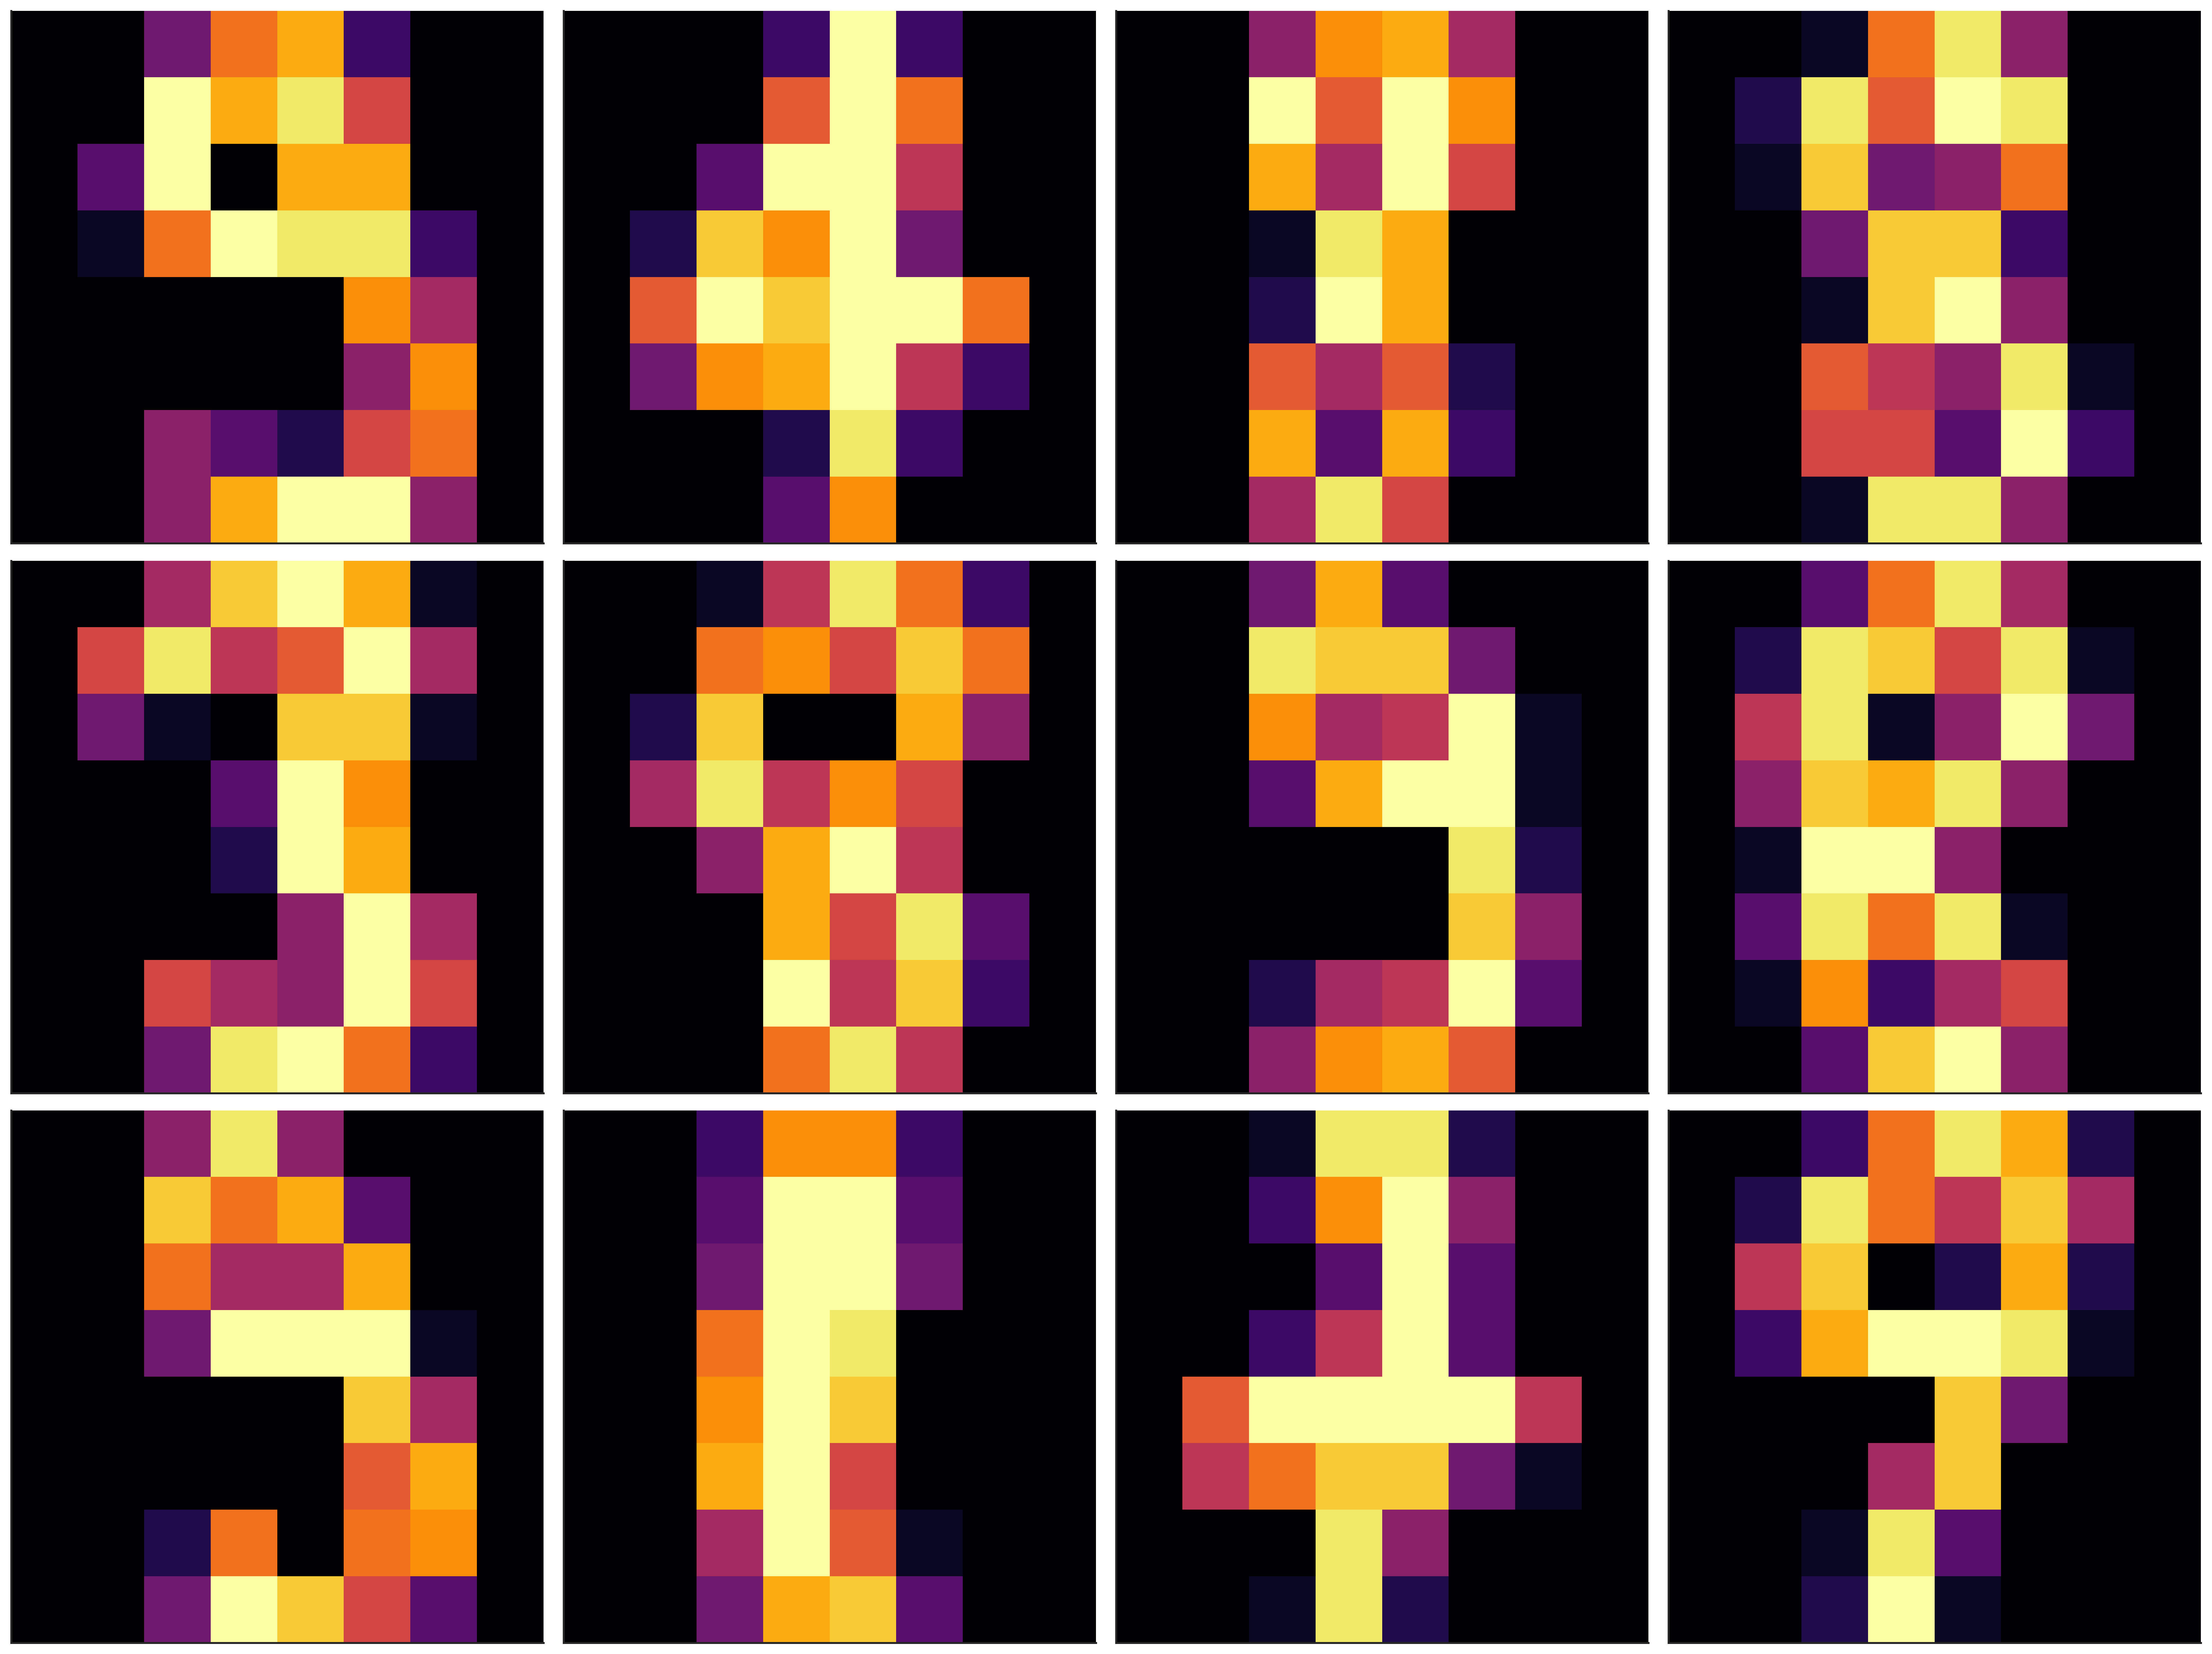

In [5]:
# примеры цифр
nrows, ncols = 3, 4
axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))[1]
it = axs.flat
rng = np.random.default_rng(42)

for digit in rng.choice(X, size=nrows*ncols, replace=False):
    ax = next(it)
    ax.imshow(digit.reshape(8,8), cmap='inferno')
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()

***
## <a id='toc1_4_'></a>[__Оценка качества__](#toc0_)

Для оценки качества классификации будем использовать `cross_val_score` с параметром `cv=5` — 5-фолдовой кросс-валидацией. 

[__sklearn.model_selection.cross_val_score__](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn-model-selection-cross-val-score)

> Evaluate a score by cross-validation.<br>
...<br>
If `scoring` is None, the estimator's default scorer (if available) is used.

Напишем функцию, которая принимает `estimator` и возвращает усредненное по пяти фолдам значение метрики качества по умолчанию введенного `estimator`: 

In [6]:
def score(estimator) -> float:
    return cross_val_score(estimator, X, y, cv=5).mean()

У объектов всех использованных в работе классов метрика качества по умолчанию — усредненная на тесте доля правильных ответов, например:

[__score__](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.score)

> Return the mean accuracy on the given test data and labels.

***
## <a id='toc1_5_'></a>[__Одиночное ДПР с параметрами по умолчанию__](#toc0_)

[__sklearn.tree.DecisionTreeClassifier__](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn-tree-decisiontreeclassifier)

> A decision tree classifier.



In [7]:
score(DecisionTreeClassifier())

0.7835701021355617

***
## <a id='toc1_6_'></a>[__Бэггинг над ДПР__](#toc0_)

Обучим бэггинг над сотней ДПР:

[__sklearn.ensemble.BaggingClassifier__](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn-ensemble-baggingclassifier)

> A Bagging classifier.<br>
A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. 

In [8]:
score(BaggingClassifier(DecisionTreeClassifier(), n_estimators=100))

0.9154333023831631

Обратим внимание, как подросло качество работы композиции решающих деревьев относительно одного решающего дерева.

***
## <a id='toc1_7_'></a>[__Бэггинг: случайные признаки один раз на все базовое дерево__](#toc0_)

Пусть теперь каждый базовый алгоритм обучается не на всех $d$ признаках, а на $\sqrt{d}$​ случайных признаках. Корень из числа признаков — часто используемая эвристика в задачах классификации, в задачах регрессии же часто берут число признаков, деленное на три. Но в общем случае можно выбирать любое другое число случайных признаков.

[__max_features__](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn-ensemble-baggingclassifier)

> The number of features to draw from `X` to train each base estimator (without replacement by default)

In [9]:
clf = BaggingClassifier(
    DecisionTreeClassifier(), 
    n_estimators=100, 
    max_features=8  # корень кв. из X.shape[1]
)

score(clf)

0.9193082636954504

***
## <a id='toc1_8_'></a>[__Бэггинг: случайные признаки при построении каждой вершины дерева__](#toc0_)

Теперь будем выбирать случайные признаки не один раз на все дерево, а при построении каждой вершины дерева.

[__max_features__](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn-tree-decisiontreeclassifier)

> The number of features to consider when looking for the best split.

In [10]:
clf = BaggingClassifier(
    DecisionTreeClassifier(max_features='sqrt'), 
    n_estimators=100
)

score(clf)

0.9404750851129681

***
## <a id='toc1_9_'></a>[__Случайный лес__](#toc0_)

[__sklearn.ensemble.RandomForestClassifier__](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn-ensemble-randomforestclassifier)

> A random forest classifier.<br>
A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

Полученный в предыдущем пункте классификатор — бэггинг на рандомизированных деревьях (в которых при построении каждой вершины выбирается случайное подмножество признаков и разбиение ищется только по ним) — соответствует алгоритму __Random Forest__. Сравним качество работы классификатора с `RandomForestClassifier`:

In [11]:
score(RandomForestClassifier())

0.9410275456515012

Теперь изучим, как качество классификации на данном датасете зависит от:

* количества деревьев, 
* количества признаков, выбираемых при построении каждой вершины дерева, 
* ограничений на глубину дерева. 

Также построим графики зависимости качества от значений этих параметров.

In [12]:
params = {
    'n_estimators': range(5, 105, 5),
    'max_features': range(4, 68, 4),
    'max_depth': range(1, 21)
}

In [13]:
def plotter(param: str, values: Iterable[int]) -> None:
    """
    График зависимости доли правильных ответов от значений values 
    выбранного параметра param класса RandomForestClassifier. 
    """
    scores = [
        score(RandomForestClassifier(**{param: value})) 
        for value in values
    ]
    plt.figure(figsize=(10,4))
    plt.plot(values, scores, lw=2)
    plt.xticks(values)
    plt.xlabel(param)
    plt.ylabel('accuracy')
    plt.grid(lw=0.5)
    plt.show()

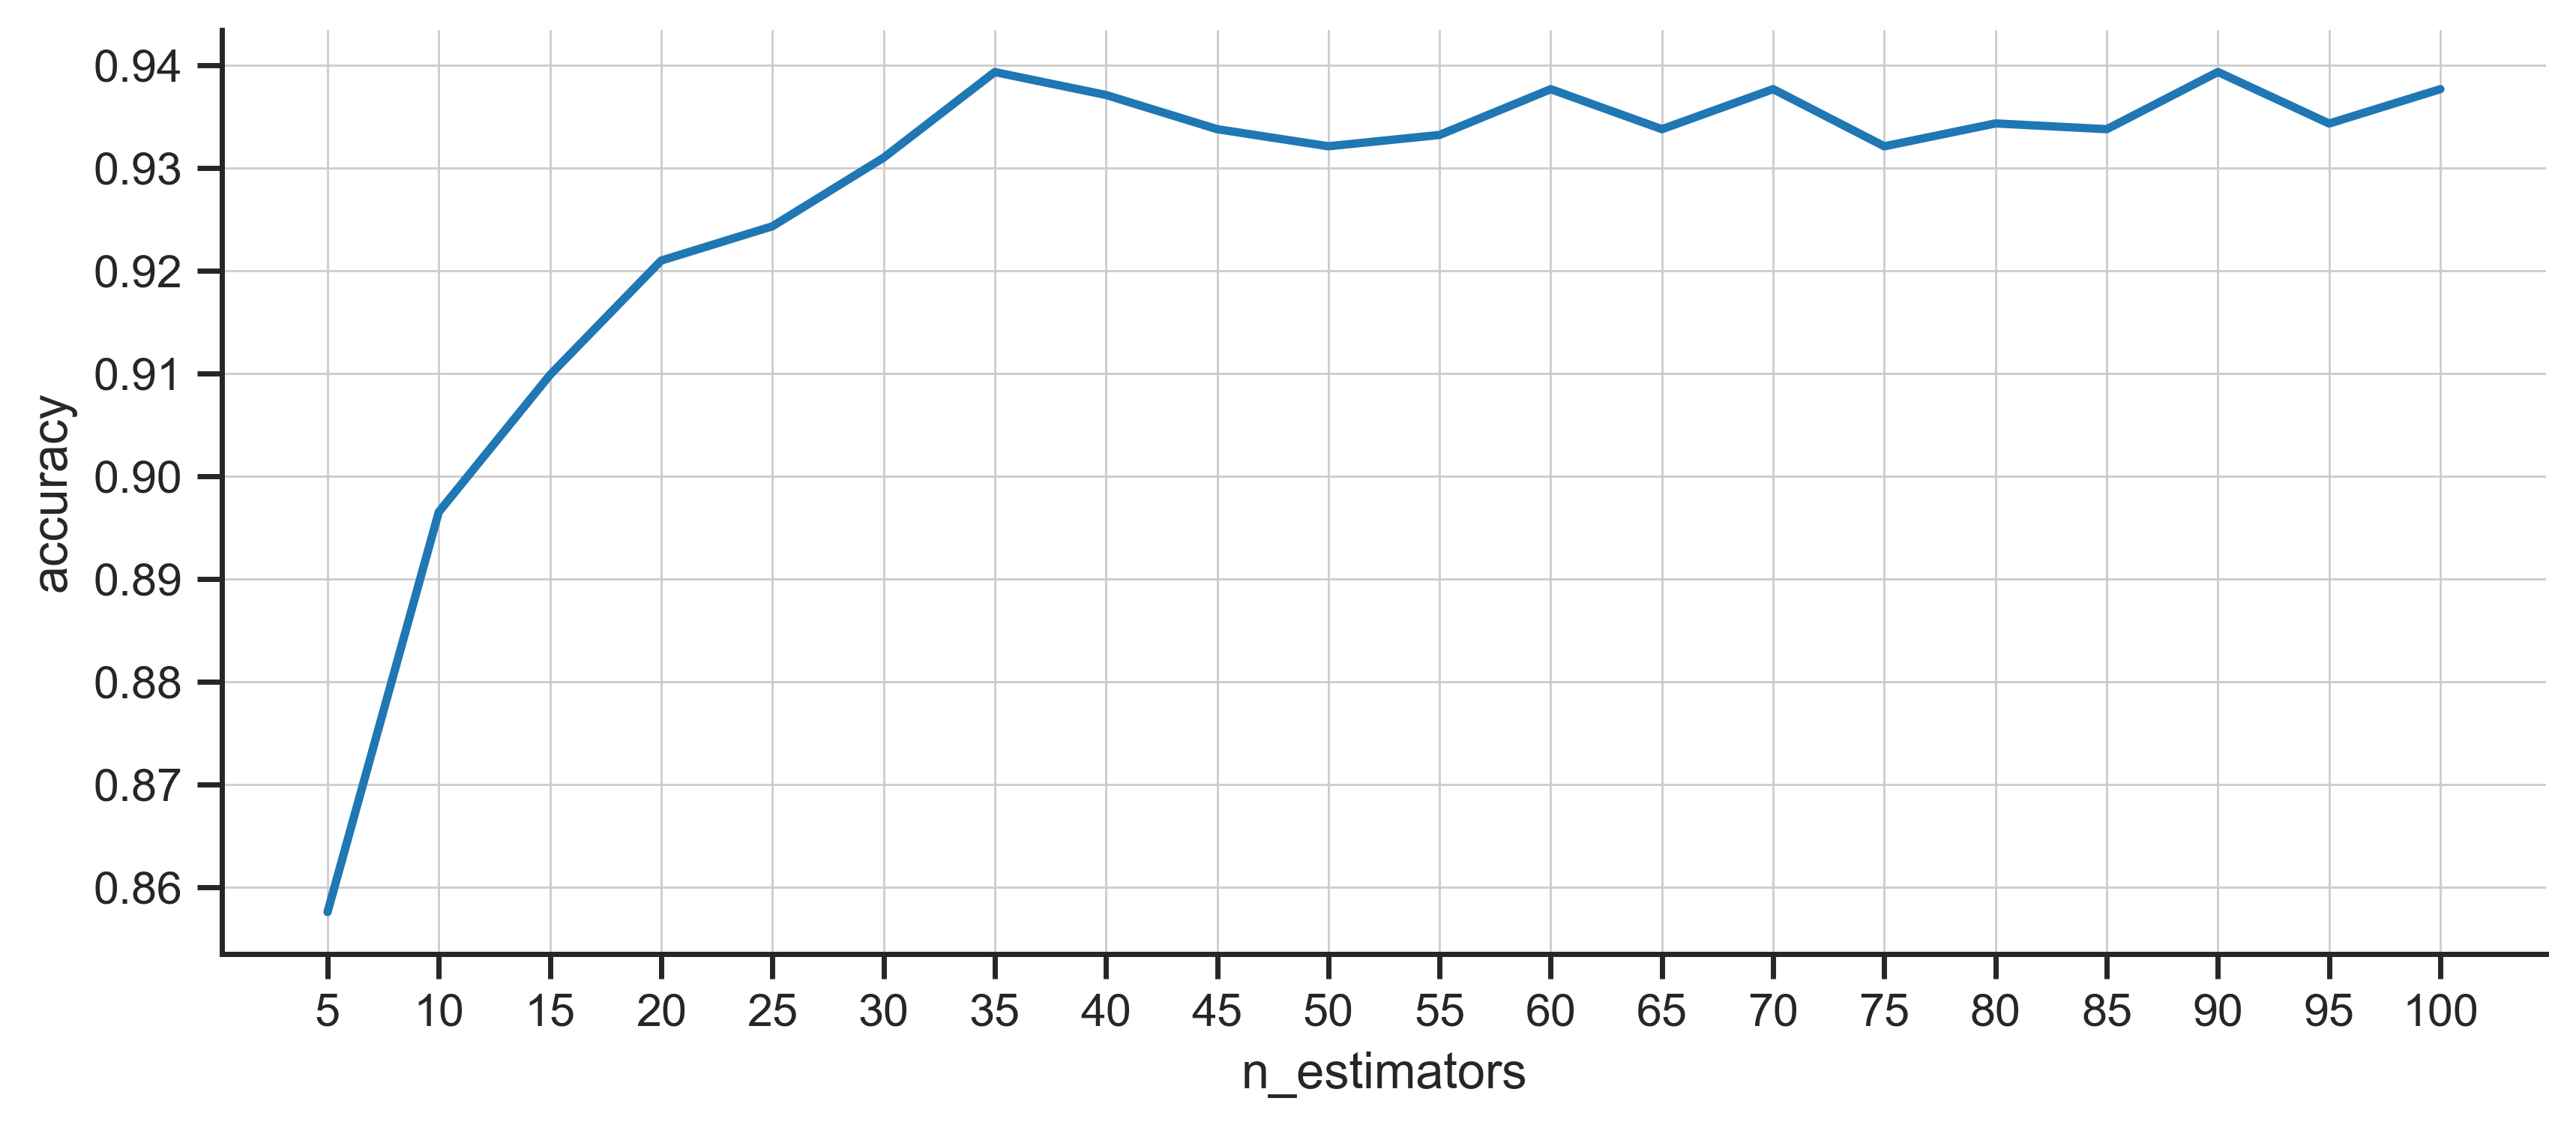

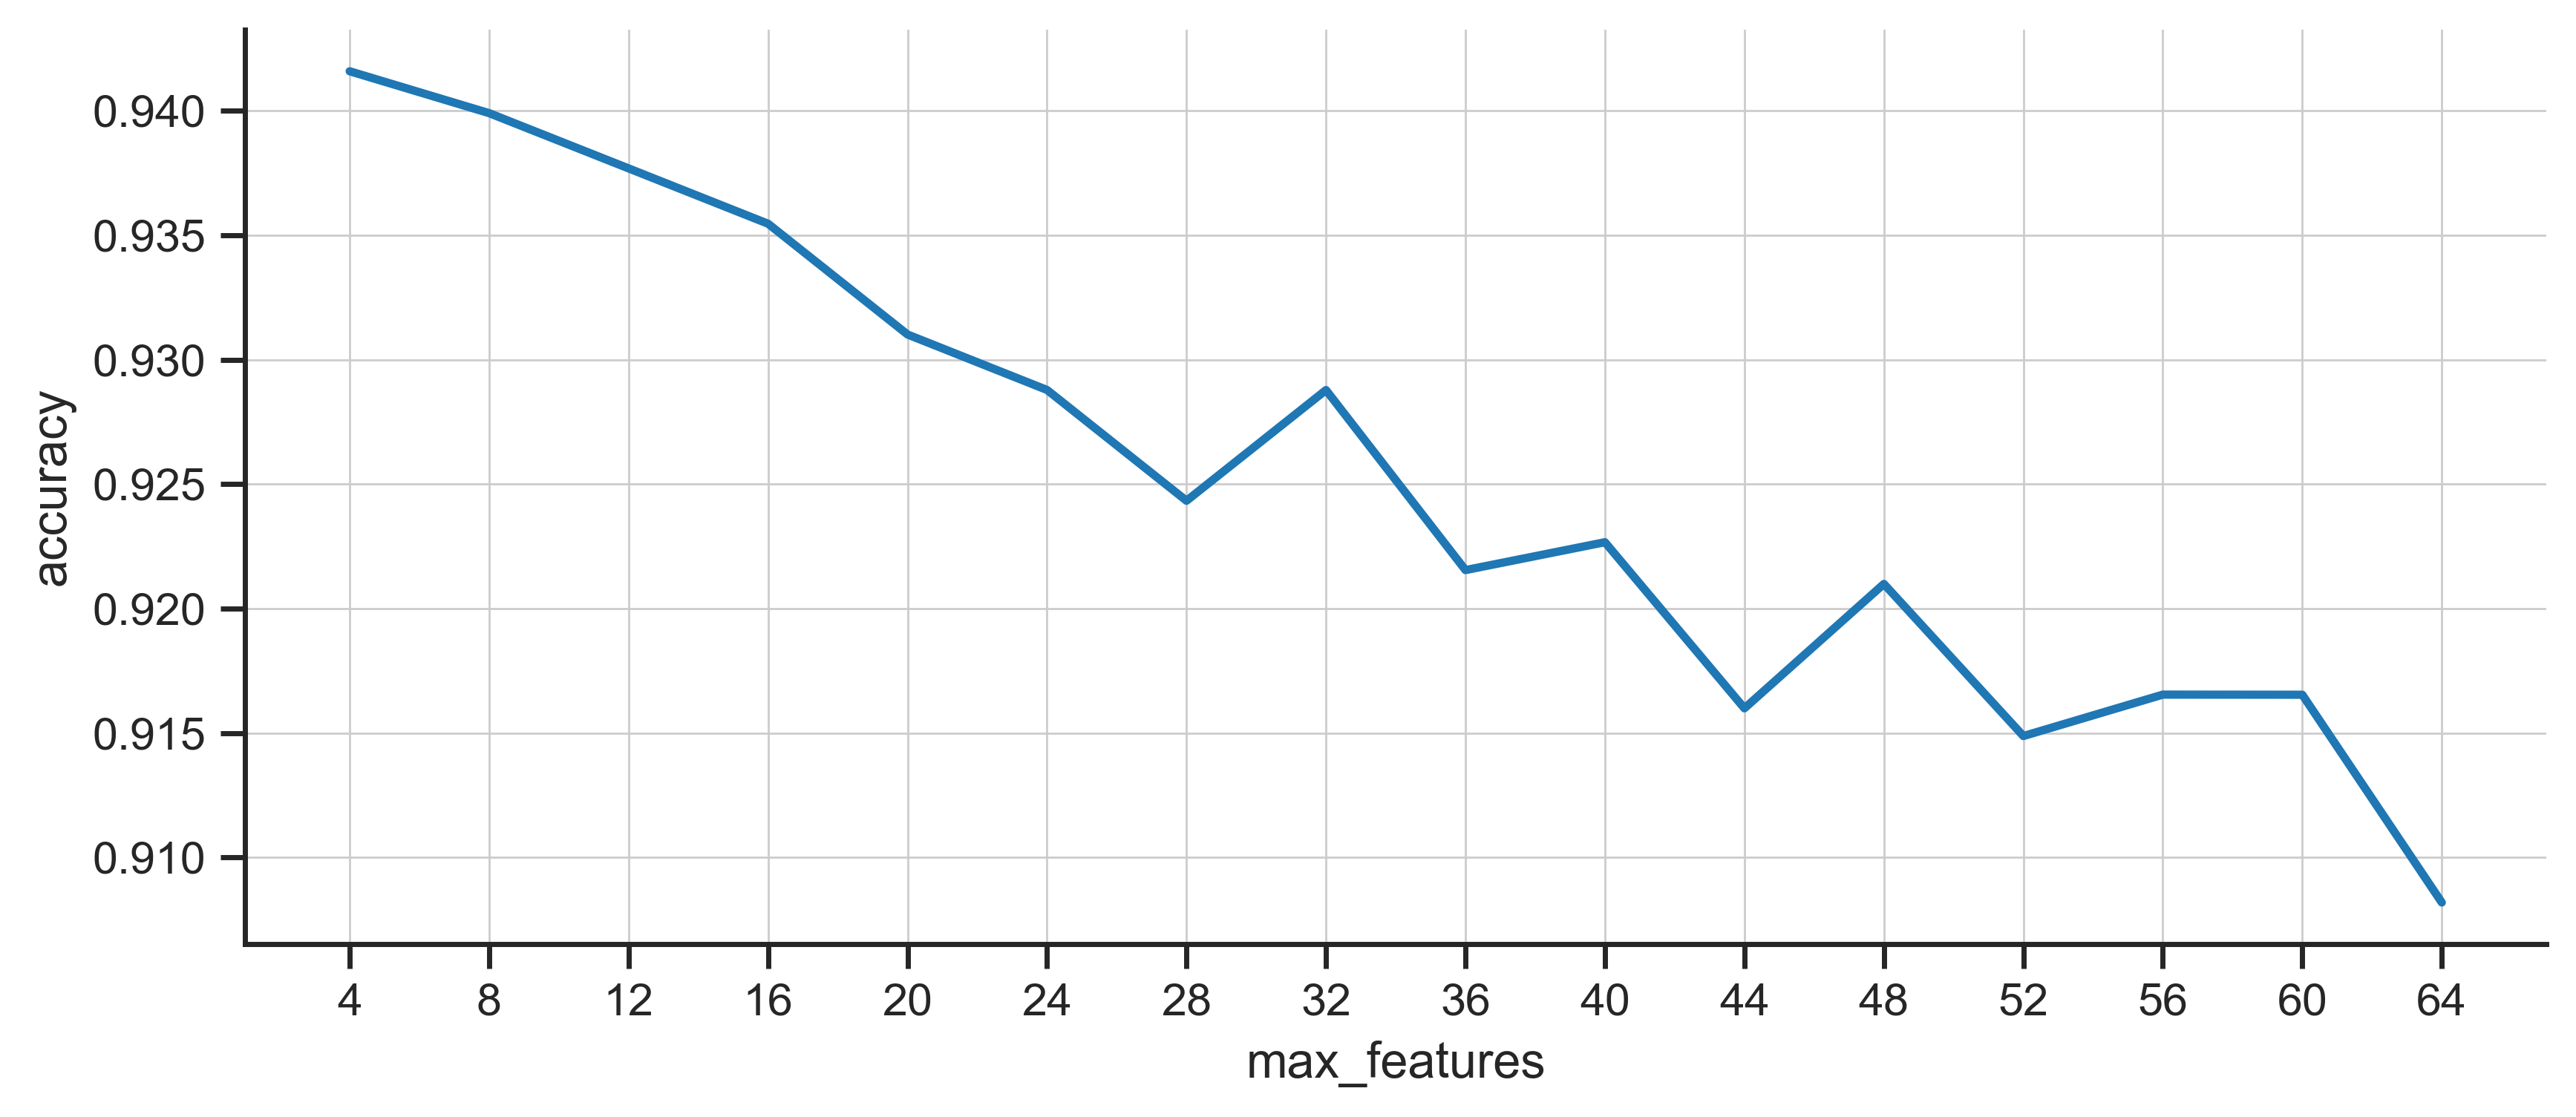

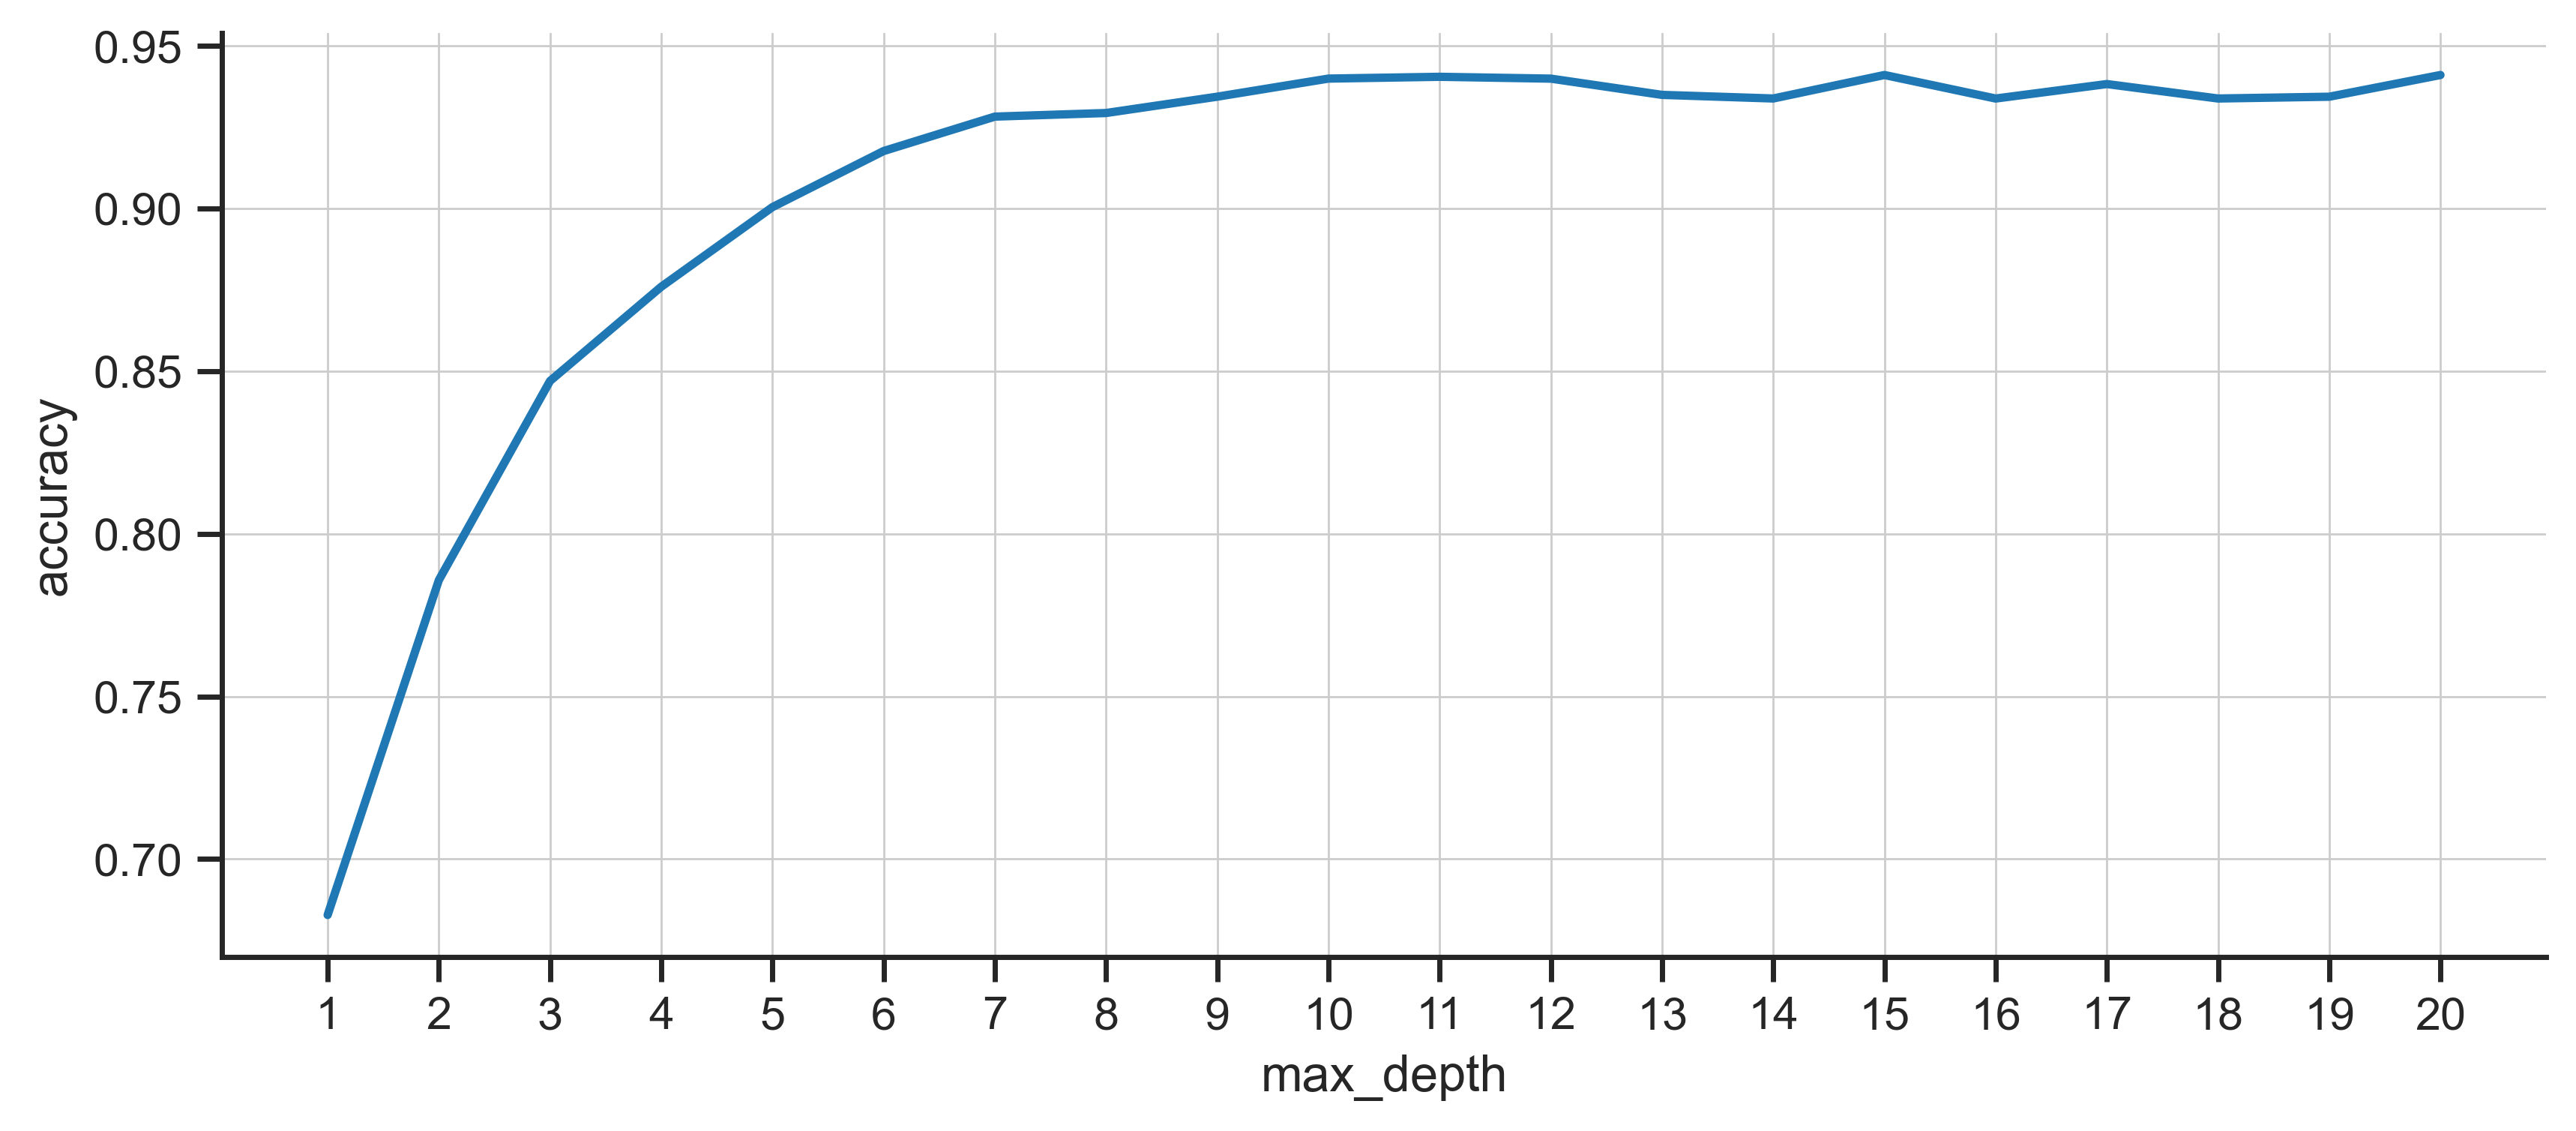

In [14]:
for item in params.items():
    plotter(*item)

***
### <a id='toc1_9_1_'></a>[__Выводы__](#toc0_)

* При малом числе деревьев случайный лес работает хуже, чем при большем числе деревьев.

* С ростом количества деревьев в случайном лесе в какой-то момент деревьев становится достаточно для высокого качества классификации, а затем качество существенно не меняется.

* При большом количестве признаков (для данного датасета 40-50) качество классификации становится хуже, чем при малом количестве признаков (5-10). Это связано с тем, что чем меньше признаков выбирается в каждом узле, тем более различными получаются деревья (ведь деревья сильно неустойчивы к изменениям в обучающей выборке), и тем лучше работает их композиция.

* При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса заметно хуже, чем без ограничений, т.к. деревья получаются недообученными. С ростом глубины качество сначала улучшается, а затем не меняется существенно, т.к. из-за усреднения прогнозов и различий деревьев их переобученность в бэггинге не сказывается на итоговом качестве (все деревья переобучены по-разному, и при усреднении они компенсируют переобученность друг друга).

***